In [1]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [2]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [3]:
pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital.csv', check_param=True, na_values='empty')

INFO:profiler.utility:[1.0819568634033203] Load Data start

INFO:profiler.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.dataset:inferred types of attributes: {
    "ProviderNumber": "text",
    "HospitalName": "text",
    "Address1": "text",
    "City": "text",
    "State": "categorical",
    "ZipCode": "text",
    "CountyName": "text",
    "PhoneNumber": "text",
    "HospitalType": "text",
    "HospitalOwner": "text",
    "EmergencyService": "categorical",
    "Condition": "text",
    "MeasureCode": "text",
    "MeasureName": "text",
    "Score": "text",
    "Sample": "text",
    "Stateavg": "text"
}
INFO:profiler.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.dataset:inferred operators of attributes: {'ProviderNumber': ['equal'], 'HospitalName': ['equal'], 'Address1': ['equal'], 'City':

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
                            [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
                            [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

INFO:profiler.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.dataset:updated types of State to 'text'
INFO:profiler.dataset:updated operators of State to ['equal']
INFO:profiler.dataset:updated types of EmergencyService to 'text'
INFO:profiler.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.dataset:updated types of Score to 'numeric'
INFO:profiler.dataset:updated operators of Score to ['equal']
INFO:profiler.dataset:updated types of Sample to 'numeric'
INFO:profiler.dataset:updated operators of Sample to ['equal']
INFO:profiler.dataset:updated inferred operators of attributes: {'ProviderNumber': ['equal'], 'Hospi

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [5]:
pf.session.load_embedding(save=True, path='data/hospital/', load=True)

INFO:profiler.utility:[3.5011730194091797] Load Embedding start

INFO:profiler.utility:[3.5648388862609863] Load Embedding execution time: 0.06366586685180664



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [6]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[4.562099933624268] Create Training Data start

INFO:profiler.transformer:needs multiplier = 165 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.transformer:use multiplier = 165, and the bound is 0.00007305
INFO:profiler.transformer:Draw Pairs
100%|██████████| 17/17 [00:00<00:00, 43.44it/s]
INFO:profiler.transformer:Number of training samples: 169830
INFO:profiler.transformer:Computing Differences
INFO:profiler.transformer:estimated missing data probability in training data is 0.0296
INFO:profiler.utility:[13.750198125839233] Create Training Data execution time: 9.188098192214966



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [7]:
autoregress_matrix = pf.session.learn_structure(sparsity=0.05, infer_order=True)

INFO:profiler.utility:[13.761672019958496] Learn Structure start

/Users/scarlet/anaconda3/envs/fd3/lib/python3.7/site-packages/sklearn/covariance/graph_lasso_.py:265: ConvergenceWarning: graphical_lasso: did not converge after 500 iteration: dual gap: 2.137e-04
  % (max_iter, d_gap), ConvergenceWarning)
INFO:profiler.learner:use threshold 0.0485
INFO:profiler.utility:[15.233947992324829] Learn Structure execution time: 1.472275972366333



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [8]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[15.246574878692627] Get Dependencies start

INFO:profiler.utility:[15.460884094238281] Get Dependencies execution time: 0.2143092155456543



Address1 -> ProviderNumber (0.0524843728747764)
Address1,ProviderNumber -> HospitalName (0.03249193550234218)
Address1,ProviderNumber,HospitalName -> City (0.05181167681011981)
Address1,ProviderNumber,HospitalName,City -> ZipCode (0.031892650330896236)
Address1,ProviderNumber,HospitalName,City,ZipCode -> CountyName (0.05301796164558589)
Address1,ProviderNumber,HospitalName,City,ZipCode,CountyName -> PhoneNumber (0.03049222216369065)
Address1,ProviderNumber,HospitalName,City,ZipCode,CountyName,PhoneNumber -> HospitalOwner (0.11215124094530413)
MeasureCode -> MeasureName (0.03255196032141561)
MeasureCode,MeasureName -> Stateavg (0.020863130860158573)
MeasureCode,MeasureName,Stateavg -> Condition (0.20444806097622803)
HospitalName,ZipCode,CountyName -> EmergencyService (0.14213990772079313)


In [21]:
import os, json
def read_fds(path='data/fds', f='TECHospital-hyfd'):
    all_fds = {}
    for line in open(os.path.join(path,f)):
        fd = json.loads(line)
        right = fd[u'dependant']['columnIdentifier']
        left = [l[u'columnIdentifier'] for l in fd[ u'determinant'][u'columnIdentifiers']]
        if right not in all_fds:
            all_fds[right] = set()
        all_fds[right].add(frozenset(left))
    return all_fds

In [22]:
gt = read_fds(f='hospital_clean-fun')

In [23]:
tp = 0
count = 0
for child in parent_sets:
    found = parent_sets[child]
    if len(found) == 0:
        continue
    count += 1
    match = False
    for parent in gt[child]:
        if set(parent).issubset(found):
            tp += 1
            match = True
            break
    if not match:
        print("{} -> {} is not valid".format(found, child))
    
print("Precision: %.4f"%(float(tp) / count))

['MeasureCode' 'MeasureName'] -> Stateavg is not valid
Precision: 0.9091


## 5. Visualization

In [9]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

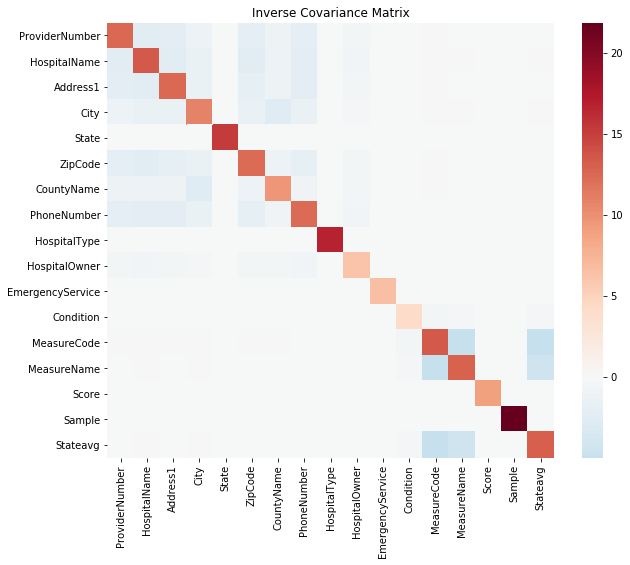

In [10]:
pf.session.visualize_inverse_covariance()

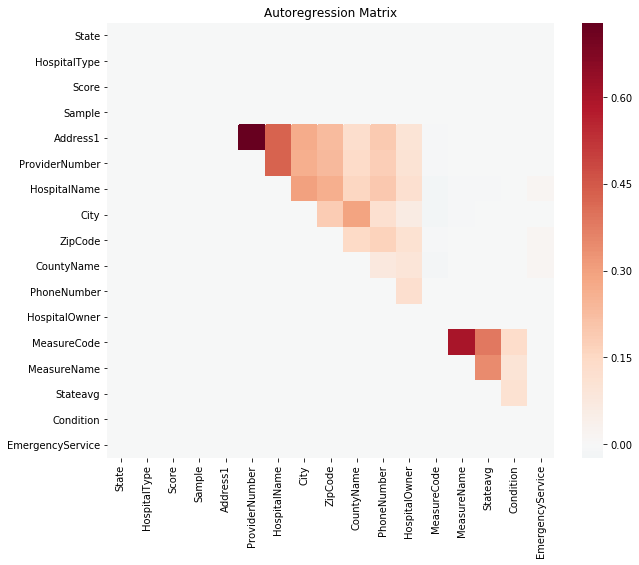

In [11]:
pf.session.visualize_autoregression()

In [19]:
pf.session.timer.get_stat()

,time_point,msg,execution_time
0,0.006402,start: Load Data,0.000000
1,0.083199,end: Load Data,0.076797
2,0.133754,start: Load Embedding,0.000000
3,0.224398,end: Load Embedding,0.090644
4,0.231105,start: Create Training Data,0.000000
5,5.802130,end: Create Training Data,5.571025
6,5.808462,start: Learn Structure,0.000000
7,5.843111,end: Learn Structure,0.034649
8,5.850562,start: Get Dependencies,0.000000
9,5.926464,end: Get Dependencies,0.075902


In [276]:
left_idx = pf.session.trans_engine.left_idx
right_idx = pf.session.trans_engine.right_idx

In [277]:
from scipy import stats
error = pf.session.trans_engine.training_data.values - np.dot(
    pf.session.trans_engine.training_data.values, pf.session.struct_engine.B.values)

In [278]:
def outlier(data, m=2):
    return abs(data - np.mean(data)) > m * np.std(data)

In [279]:
l = left_idx[np.sum(outlier(error)*1, axis=1) > 0]
r = right_idx[np.sum(outlier(error)*1, axis=1) > 0]

In [280]:
import pandas as pd
vio_left_idx = left_idx[np.sum(outlier(error)*1, axis=1) > 0]
unique, counts = np.unique(vio_left_idx, return_counts=True)
vio_left = pd.DataFrame(data=zip(unique, counts), columns=['tid','count'])
vio_left.set_index('tid', inplace=True)

In [281]:
vio_right_idx = right_idx[np.sum(outlier(error)*1, axis=1) > 0]
unique, counts = np.unique(vio_right_idx, return_counts=True)
vio_right = pd.DataFrame(data=zip(unique, counts), columns=['tid','count'])
vio_right.set_index('tid', inplace=True)

In [282]:
vio = vio_left.merge(vio_right, on='tid', how='outer').sum(axis=1)

In [283]:
def update_vio(vio_left_idx, vio_right_idx):
    unique, counts = np.unique(vio_left_idx, return_counts=True)
    vio_left = pd.DataFrame(data=zip(unique, counts), columns=['tid','count'])
    unique, counts = np.unique(vio_right_idx, return_counts=True)
    vio_right = pd.DataFrame(data=zip(unique, counts), columns=['tid','count'])
    vio_right.set_index('tid', inplace=True)
    vio = vio_left.merge(vio_right, on='tid', how='outer').sum(axis=1)
    return vio

In [284]:
def drop_max_vio(vio_left_idx, vio_right_idx, vio):
    max_vio_idx = vio.idxmax()
    max_vio = vio.loc[max_vio_idx]
    print("max vio: [%d] %d"%(max_vio_idx, max_vio))
    drop_idx = (vio_left_idx == max_vio_idx) | (vio_right_idx == max_vio_idx)
    vio_left_idx = vio_left_idx[~drop_idx]
    vio_right_idx = vio_right_idx[~drop_idx]
    vio = update_vio(vio_left_idx, vio_right_idx)
    print("remaining violations: %d"%vio.sum())
    return left_idx, right_idx, vio

In [285]:
while vio.sum() > 100:
    left_idx, right_idx, vio = drop_max_vio(vio_left_idx, vio_right_idx, vio)

max vio: [601] 115
remaining violations: 531031
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
r

remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations

remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations: 530923
max vio: [875] 1060
remaining violations

KeyboardInterrupt: 